# HOMEWORK 2: DESIGN OF EXPERIMENTS

**THIS HOMEWORK IS SUBMITTED AS A COLAB NOTEABOOK IN YOUR STUDENT FOLDER.**

# Wolf Model

In [1]:
'''Codes and Constants for the Wolf Model'''


################## CONSTANTS #############################
WOLF_MODEL = """
// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k, J4_kg;
  const J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2, J9_k, J10_k;
end
"""

# (15 pt) Question 1: DOE Concepts

## Question

A model is being constructed of lab data in which all parameter values are known as well as all initial concentrations. However, there are 3 possibilities for reaction R1
and two possibilities for reaction R2.
You want to construct a design for experiments to evaluate which combinations of reactions
for R1 and R2 best fit the lab data.
1. What are the factors and levels for your DOE?
1. What are the experiments that you would perform? Justify your answer.
1. How would you change your experimental design if there is an unknown parameter value for each reaction?

## Answer

1. There are two factors: R1, R2. There are 3 levels for R1 and two levels for R2.
1. You can easily do a factorial design, which explores all combinations of factor levels (and so
is the most comprehensive). This is possible because there are a total of 6 experiments.
1. If unknown parameters must be evaluated as well, then we have to consider a lot more levels.
This would require a 1WD or possibly a 2WD depending on the number of levels considered
for the parameters.

# (70 pt) Question 2: Calculating DOE parameters for 2WD

## Questions

In this question, you will implement functions that calculate the DOE parameters $\mu$, $\alpha_{i, k_i}$,
and $\beta_{i, k_i, j, k_j}$ and visualize the results.

1. (40 pt) Implement the function ``estimate2WDParameters`` that estimates the parameters of a 2WD.
The specifics are:
   * **Inputs**
       * modelStr - a string that is an Antimony model
       * parameters - a tuple of two factor names
       * percents - list of int that are percentage changes in parameters
       * responseFunc - function that calculates the $y$ values; its input is a DataFrame (the result of a tellurium simulation); its output is a scalar value
   * **Outputs**
       * mu - float
       * alphaDF - pandas dataframe; column is a parameter name; index is a level
       * betaDF - pandas dataframe; column is a level for parameter 1; index is a level for parameter 2
 
   Implement a ``responseFunc`` that calculates the maximum value of Glucose over the simulation run, and use this function in your test.
   Remember that each function you write should abide by the rules for writing software (including tests).
   
1. (20 pt) Implement functions that display heatmaps for alphaDF and betaDF and display
the output for the parameters  "J1_Ki" and "J1_k1"
over levels ranging from -20% to 20%.

1. (10 pt) Answer the following:
   1. Which of the two parameters has the most effect on the response?
   1. Over what range of levels would it be reasonable to predict the response as the
   sum of effects of the factor levels?

## Answer

### Part 1: Implementation

In [2]:
try:
    import tellurium as te
except:
    !pip install -q tellurium==2.2.0
    import tellurium as te
import numpy as np
import pandas as pd

In [3]:
# Constants
MODEL_STR = """
$X -> S1; k1
S1 -> S2; k2*S1

k1 = 1
k2 = 1
X = 10
"""
RR = te.loada(MODEL_STR)
TIME = "time"

In [4]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index(TIME)
    return df

# Tests
df = arrToDF(RR.simulate())
assert(isinstance(df, pd.DataFrame))

In [5]:
def runSimulation(modelStr, parameterDct):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    modelStr: str (Antimony model)
    parameterDct: dict
       key: parameter
       value: int
           percent change
       
    Returns
    -------
    DataFrame: results of simulation
    """
    roadrunner = te.loada(modelStr)
    for parameter, percent in parameterDct.items():
        baseValue = roadrunner[parameter]
        roadrunner[parameter] = baseValue*(1 + 0.01*percent)
    # Run the simulation
    data = roadrunner.simulate()
    return arrToDF(data)

# TESTS
df = runSimulation(MODEL_STR, {})
RR.reset()
df_base = arrToDF(RR.simulate())
assert(df.equals(df_base))

In [6]:
def responseFunc(simulationDF, molecule="Glucose", skip_until_time=1.0):
    df = simulationDF[simulationDF.index > skip_until_time]
    return df[molecule].max()

In [7]:
def estimate2WDParameters(modelStr, parameters, percents, responseFunc):
    """
    Runs experiments for multiple factors at different percent changes in factor levels.
    
    Parameter
    ---------
    modelStr: antimony model
    parameters: tuple of two parameter names
    percents: list-int of percentage change in parameter values
    responseFunc: Function that inputs a dataframe of simulation results and outputs a scalar response
        
    Returns
    -------
    mu: scalar
    alphaDF: DataFrame - columns are parameters, index is level
    betaDF: columns are levels of parameter 1; index is level of parameter 2
    """
    # Initializations
    parameter1 = parameters[0]
    parameter2 = parameters[1]
    # Calculations
    mu = responseFunc(runSimulation(modelStr, {}))
    zeroes = np.repeat(0, len(percents))
    alphaDF = pd.DataFrame({parameters[0]: zeroes, parameters[1]: zeroes})
    alphaDF.index = percents
    betaDct = {p: zeroes for p in percents}
    betaDF = pd.DataFrame(betaDct, columns=percents, index=percents)
    betaDF.index.name = parameter1
    betaDF.columns.name = parameter2
    # Calculate the changes
    for percent1 in percents:
        for percent2 in percents:
            cur_percents = [percent1, percent2]
            #indices.append("%d_%d" % (percent1, percent2))
            parameterDct = {parameter1: percent1, parameter2: percent2}
            y_val = responseFunc(runSimulation(modelStr, parameterDct))
            # Calculate alpha
            for parameter, percent in [(parameter1, percent1), (parameter2, percent2)]:
                simulationDF = runSimulation(modelStr, {parameter: percent})
                alphaDF.loc[percent, parameter] = responseFunc(simulationDF) - mu
            # calculate beta
            betaDF.loc[percent1, percent2] = \
                  y_val - mu  \
                       - alphaDF.loc[percent1, parameter1] - alphaDF.loc[percent2, parameter2]
    #
    return mu, alphaDF, betaDF
                    
# Tests
percents = [-20, -15, -10, -5, -3, -2, 0, 2, 3, 5, 10, 15, 20]
parameters = ["J1_Ki", "J1_k1"]
mu, alphaDF, betaDF = estimate2WDParameters(WOLF_MODEL, parameters, percents, responseFunc)

In [8]:
mu

3.3153525064265574

In [9]:
alphaDF

,J1_Ki,J1_k1
-20,4.119460,1.088358
-15,2.659598,0.757272
-10,1.979032,0.489967
-5,0.813505,0.232197
-3,0.463121,0.141791
-2,0.341318,0.093960
0,0.000000,0.000000
2,-0.330187,-0.089535
3,-0.469294,-0.132386
5,-0.709357,-0.214274


In [10]:
betaDF

J1_k1,-20,-15,-10,-5,-3,-2,0,2,3,5,10,15,20
J1_Ki,,,,,,,,,,,,,
-20,-0.443943,-0.237285,-0.052490,0.040789,0.037624,0.031421,0.0,-0.064804,-0.113633,-0.258882,-0.380447,-0.509059,-0.626024
-15,0.318912,0.118628,0.007175,-0.193474,-0.113911,-0.073908,0.0,0.063553,0.091354,0.138929,0.214037,0.232557,0.201254
-10,-0.506582,-0.252930,-0.111793,-0.023565,-0.012110,-0.006028,0.0,-0.004111,-0.010165,-0.030178,-0.123717,-0.273410,-0.470991
-5,0.112110,0.190595,0.165801,0.102504,0.059395,0.040173,0.0,-0.042743,-0.064246,-0.024384,0.027135,0.012283,0.003549
-3,0.118718,0.140673,0.075922,0.003467,-0.028776,-0.038419,0.0,0.029251,0.039209,0.049248,0.070349,0.009915,-0.040615
-2,0.050900,0.053583,-0.013923,-0.057262,-0.061550,-0.045545,0.0,0.019298,0.037322,0.031490,-0.009735,-0.046909,-0.076701
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.029098,0.085539,-0.046835,-0.025774,-0.021768,-0.015185,0.0,0.015458,0.022920,0.037140,0.068055,0.114685,0.176379
3,-0.024327,-0.072209,-0.080855,-0.043258,-0.031933,-0.021855,0.0,0.021627,0.031995,0.051643,0.109649,0.188827,0.247681


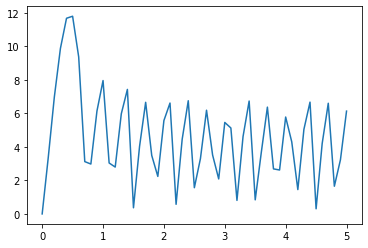

In [11]:
import matplotlib.pyplot as plt
df = runSimulation(WOLF_MODEL, {"J1_Ki": -20})
plt.plot(df.index, df["Glucose"])

### Part 2: Visualization

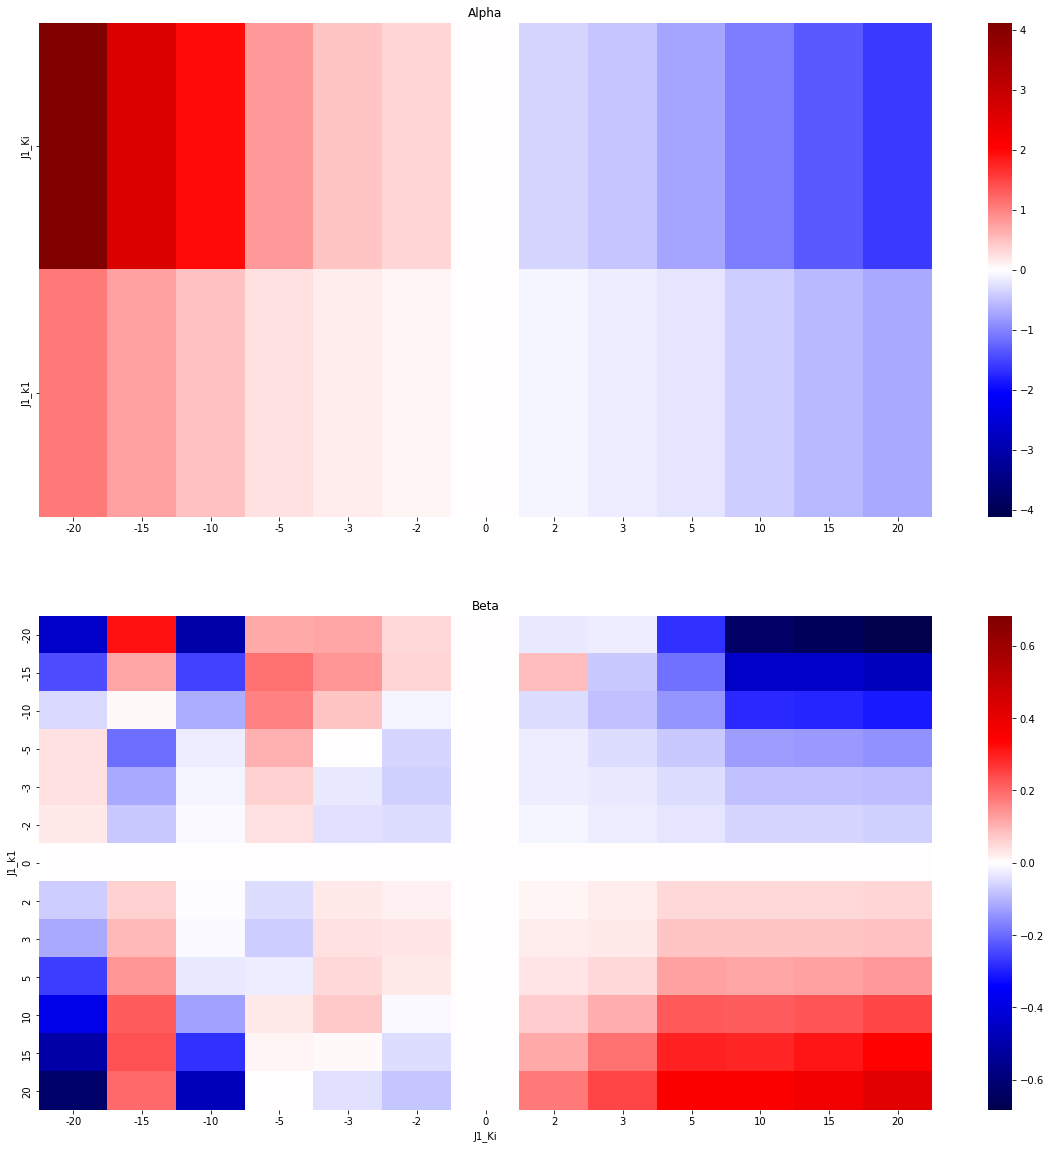

In [12]:
import seaborn as sns
def visualize2WD(alphaDF, betaDF):
    """
    Provides visualizations for the parameters of the 2WD
    
    Parameters
    ----------
    alphaDF: DataFrame
        columns: factors
        rows: levels
    betaDF: DataFrame
        columns: factor levels
        index: factor levels
    """
    def plot(df, ax, title):
        vmin = df.min().min()
        vmax = df.max().max()
        upper = max(np.abs(vmin), vmax)
        sns.heatmap(df.T, cmap='seismic', vmin=-upper, vmax=upper, ax=ax)
        ax.set_title(title)
    #
    _, axes = plt.subplots(2, figsize=(20, 20))
    plot(alphaDF, axes[0], "Alpha")
    plot(betaDF, axes[1], "Beta")

# TESTS
visualize2WD(alphaDF, betaDF)

### Part 3: Analysis

**Which of the two parameters has the most effect on the response?**

``J1_Ki`` consistently has values of larger magnitude over the levels studied.

**Over what range of levels would it be reasonable to predict the response as the
   sum of effects of the factor levels?**
   
From the heatmap for $\beta$, it seems that there's little interaction in the range $\pm5\%$.

# (15 pt) Question 3: Complexity of experimental designs

## Question

Consider a design with 16 factors and 7 levels (including the baseline).
How many experiments are there for a 1WD? 2WD? 10WD?

## Answers

In [ ]:
from scipy.special import comb
def calcNumberExperiment(numFactor, numLevel, numWay):
    """ 
    Calculates the number of experiments for a design.

    Parameters
    ----------
    numFactor: int
        Number of factors in the design
    numLevel: int
        number of levels for each factor (without baseline)
    numWay: int
        n-way design
    
    Returns
    -------
    int
    """
    if numWay == 0:
        return 1
    result = calcNumberExperiment(numFactor, numLevel, numWay-1)
    result += int(comb(numFactor, numWay, exact=False)*(numLevel**numWay))
    return result

# Tests
num1 = calcNumberExperiment(10, 3, 1)
assert(num1 == 10*3 + 1)


In [ ]:
print(calcNumberExperiment(16,  6, 1))

In [ ]:
print(calcNumberExperiment(16,  6, 2))

In [ ]:
print(calcNumberExperiment(16,  6, 3))